In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
    try:
        tf.config.set_logical_device_configuration(
            gpus[0],
            [tf.config.LogicalDeviceConfiguration(memory_limit=6*1024)])
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)


2026-01-26 02:59:38.510983: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1769396380.241933  665029 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6144 MB memory:  -> device: 0, name: AMD Radeon RX 9070 XT, pci bus id: 0000:03:00.0


In [2]:
# Data processing and model train

from libs.ml import AtmosphericalData
from tensorflow import keras
from keras.src.callbacks import EarlyStopping
def train_model(target_column:str, date_col: str, train_column: str, n_steps:int, training_args: dict, model_args: list, compile_args: dict = None):
    ## Read data and preprocessing

    inside = []
    for v in model_args:
        layer = getattr(keras.layers, v['layer'])

        inside.append(layer(v['units'], **v['args']))

    model = keras.models.Sequential(inside)

    ad = AtmosphericalData(model=model, path=f"./data/{target_column}/{target_column}_decomposition.csv", use_cudnn=False)
    del model

    print(ad.df.columns)

    ad.convert_date(date_col=date_col)
    ad.target_selection(train_column)
    ad.data_preprocessing(n_steps=n_steps, train_vol=0.9)

    ## Train data
    ad.train_data(
        epochs=training_args['epochs'],
        batch_size=training_args['batch_size'],
        validation_split=training_args['validation_split'],
        verbose=training_args['verbose'],
        **compile_args
    )


    ## Test trained model
    ad.test_model()


    ## Plot comparison
    ad.plot_tests()

    return ad

In [3]:
target = 'tmax(degC)'

Index(['date', 'seasonal', 'trend', 'resid', 'observed', 'weights', 'rt'], dtype='object')
X shape: (777, 3, 3)
y shape: (777,)
Epoch 1/150


2026-01-26 02:59:41.316760: I external/local_xla/xla/service/service.cc:163] XLA service 0x5c130b040ee0 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
2026-01-26 02:59:41.316772: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): AMD Radeon RX 9070 XT, AMDGPU ISA version: gfx1201
2026-01-26 02:59:41.333883: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-26 02:59:41.457817: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


36/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4348 - mae: 0.7855 

I0000 00:00:1769396382.435490  665142 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2026-01-26 02:59:42.644022: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.4238 - mae: 0.7852 - val_loss: 0.3638 - val_mae: 0.7144
Epoch 2/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4175 - mae: 0.7750 - val_loss: 0.3601 - val_mae: 0.7119
Epoch 3/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4131 - mae: 0.7690 - val_loss: 0.3574 - val_mae: 0.7099
Epoch 4/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4114 - mae: 0.7667 - val_loss: 0.3569 - val_mae: 0.7085
Epoch 5/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4093 - mae: 0.7634 - val_loss: 0.3565 - val_mae: 0.7094
Epoch 6/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4079 - mae: 0.7608 - val_loss: 0.3571 - val_mae: 0.7086
Epoch 7/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4071 - mae: 0.7602 - val_loss: 0.3569 - val_mae: 0.7093
Epoch 8/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4064 - mae: 0.7585 - val_loss: 0.3568 - val_mae: 0.7090
Epoch 9/150
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4057 - mae: 0.

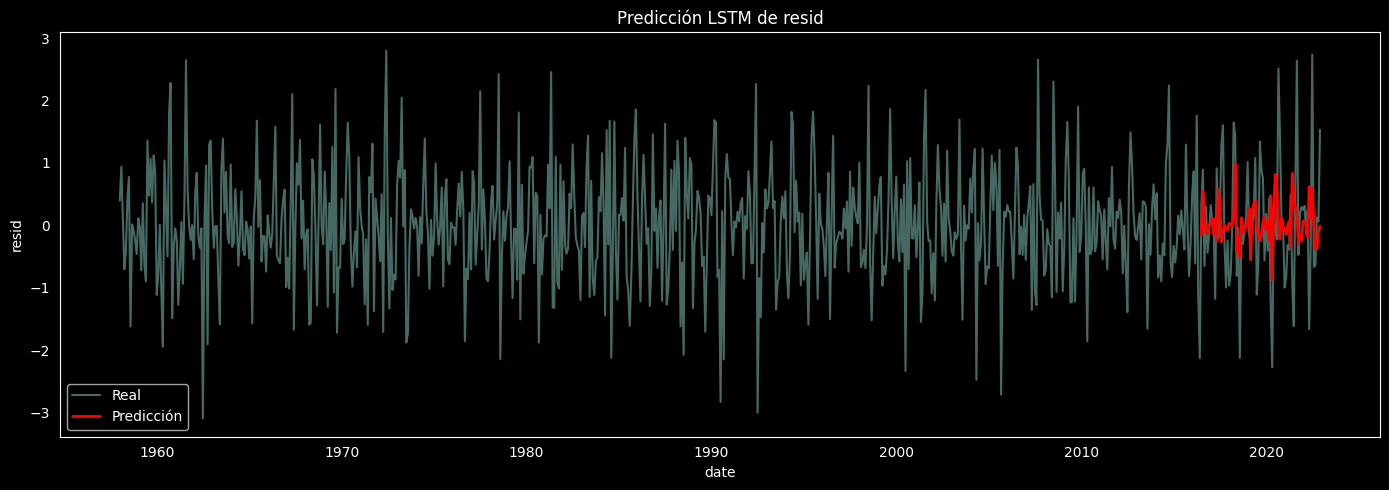

In [4]:
n_steps_r = 3

model_args_r = [
    {'layer': 'Input', 'units': (n_steps_r, 3), 'args': {}},
    {'layer': 'LSTM', 'units':16, 'args': {'return_sequences': False, 'use_cudnn': False}},
    {'layer': 'Dense', 'units': 1, 'args': {}},
]

compile_args_r = {
    'optimizer': 'adam',
    'loss': 'huber',
    'metrics': ['mae'],
}

training_args_r = {
    'epochs': 150,
    'batch_size': 12,
    'validation_split': 0.2,
    'callbacks': [EarlyStopping(patience=20, restore_best_weights=True)],
    'verbose': 1
}

ad_r = train_model(
    target_column=target,
    date_col='date',
    train_column='resid',
    n_steps=n_steps_r,
    training_args=training_args_r,
    model_args=model_args_r,
    compile_args=compile_args_r
)

Index(['date', 'seasonal', 'trend', 'resid', 'observed', 'weights', 'rt'], dtype='object')
X shape: (756, 24, 3)
y shape: (756,)
Epoch 1/150


2026-01-26 03:00:02.993598: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-26 03:00:02.993617: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-01-26 03:00:02.993630: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - loss: 0.6098 - mse: 0.6098 - val_loss: 0.2935 - val_mse: 0.2935
Epoch 2/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3299 - mse: 0.3299 - val_loss: 0.2544 - val_mse: 0.2544
Epoch 3/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2113 - mse: 0.2113 - val_loss: 0.1628 - val_mse: 0.1628
Epoch 4/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1470 - mse: 0.1470 - val_loss: 0.0905 - val_mse: 0.0905
Epoch 5/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1196 - mse: 0.1196 - val_loss: 0.0790 - val_mse: 0.0790
Epoch 6/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1056 - mse: 0.1056 - val_loss: 0.0835 - val_mse: 0.0835
Epoch 7/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0989 - mse: 0.0989 - val_loss: 0.0824 - val_mse: 0.0824
Epoch 8/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0958 - mse: 0.0958 - val_loss: 0.0876 - val_mse: 0.0876
Epoch 9/150
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0888 - mse: 0

2026-01-26 03:00:40.005471: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step
%RMSE: 8.52223601419088
%MAE: 6.957374762373762


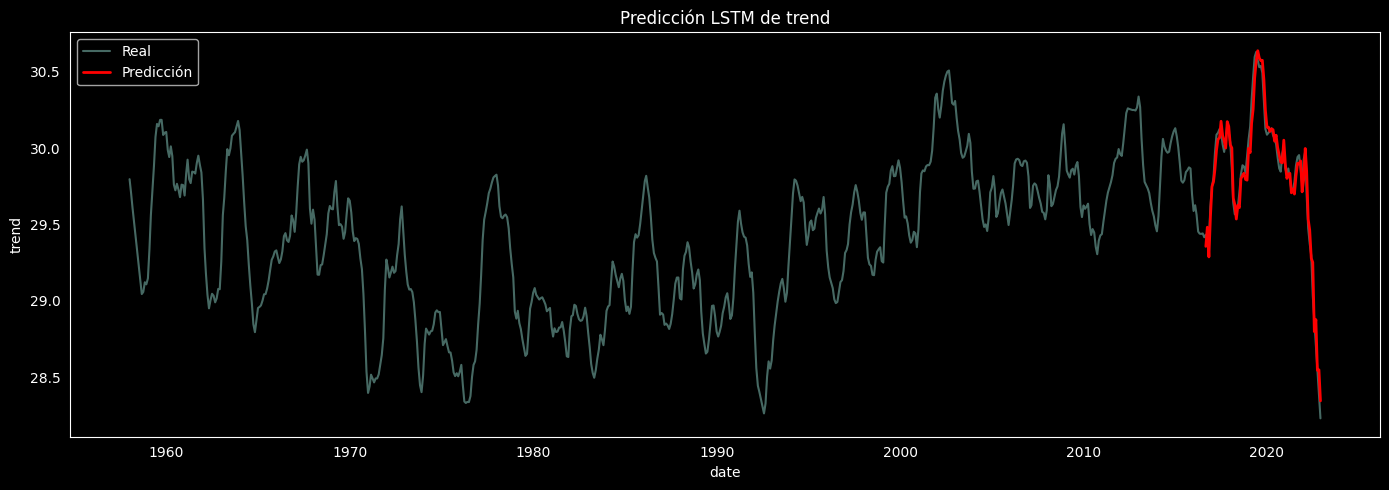

In [5]:
n_steps_t = 24
model_args_t = [
    {'layer': 'Input', 'units': (n_steps_t, 3), 'args': {}},
    {'layer': 'LSTM', 'units':64, 'args': {'return_sequences': True, 'use_cudnn': False}},
    {'layer': 'LSTM', 'units':32, 'args': {'return_sequences': False, 'use_cudnn': False}},
    {'layer': 'Dense', 'units': 1, 'args': {}},
]

compile_args_t = {
    'optimizer': 'adam',
    'loss': 'mse',
    'metrics': ['mse'],
}

training_args_t = {
    'epochs': 150,
    'batch_size': 24,
    'validation_split': 0.15,
    'callbacks': [EarlyStopping(patience=20, restore_best_weights=True)],
    'verbose': 1
}

ad_t = train_model(
    target_column=target,
    date_col='date',
    train_column='trend',
    n_steps=n_steps_t,
    training_args=training_args_t,
    model_args=model_args_t,
    compile_args=compile_args_t
)


Index(['date', 'seasonal', 'trend', 'resid', 'observed', 'weights', 'rt'], dtype='object')
X shape: (768, 12, 3)
y shape: (768,)
Epoch 1/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.5808 - mse: 0.5808 - val_loss: 0.1558 - val_mse: 0.1558
Epoch 2/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0835 - mse: 0.0835 - val_loss: 0.0444 - val_mse: 0.0444
Epoch 3/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0348 - mse: 0.0348 - val_loss: 0.0265 - val_mse: 0.0265
Epoch 4/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0204 - val_mse: 0.0204
Epoch 5/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0192 - mse: 0.0192 - val_loss: 0.0167 - val_mse: 0.0167
Epoch 6/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0162 - mse: 0.0162 - val_loss: 0.0144 - val_mse: 0.0144
Epoch 7/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0144 - mse: 0.0144 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 8/150
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

2026-01-26 03:01:16.077492: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.


1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x73a89bea8dc0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step
%RMSE: 0.0002658509566412267
%MAE: 0.00019482744432536498


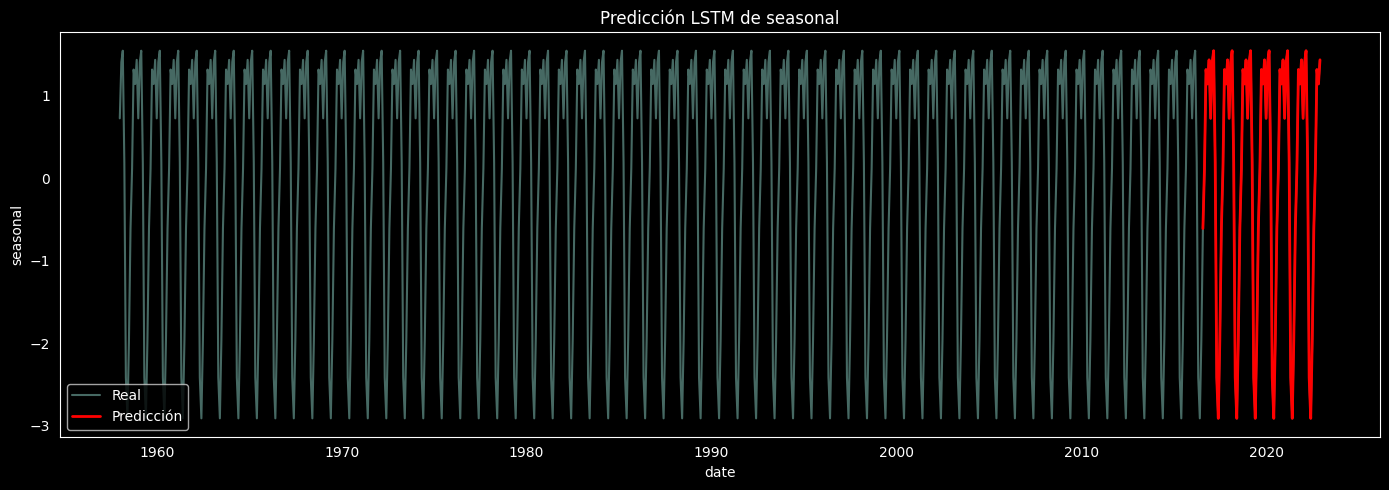

In [6]:
n_steps_s = 12

model_args_s = [
    {'layer': 'Input', 'units': (n_steps_s, 3), 'args': {}},
    {'layer': 'LSTM', 'units':48, 'args': {'return_sequences': True, 'use_cudnn': False}},
    {'layer': 'LSTM', 'units':16, 'args': {'return_sequences': False, 'use_cudnn': False}},
    {'layer': 'Dense', 'units': 1, 'args': {}},
]

compile_args_s = {
    'optimizer': 'adam',
    'loss': 'mse',
    'metrics': ['mse'],
}

training_args_s = {
    'epochs': 150,
    'batch_size': 16,
    'validation_split': 0.15,
    'callbacks': [EarlyStopping(patience=20, restore_best_weights=True)],
    'verbose': 1
}

ad_s = train_model(
    target_column=target,
    date_col='date',
    train_column='seasonal',
    n_steps=n_steps_s,
    training_args=training_args_s,
    model_args=model_args_s,
    compile_args=compile_args_s
)


Index(['date', 'seasonal', 'trend', 'resid', 'observed', 'weights', 'rt'], dtype='object')
X shape: (756, 24, 3)
y shape: (756,)
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step
%RMSE: 113.12179648714518
%MAE: 88.17217676263107


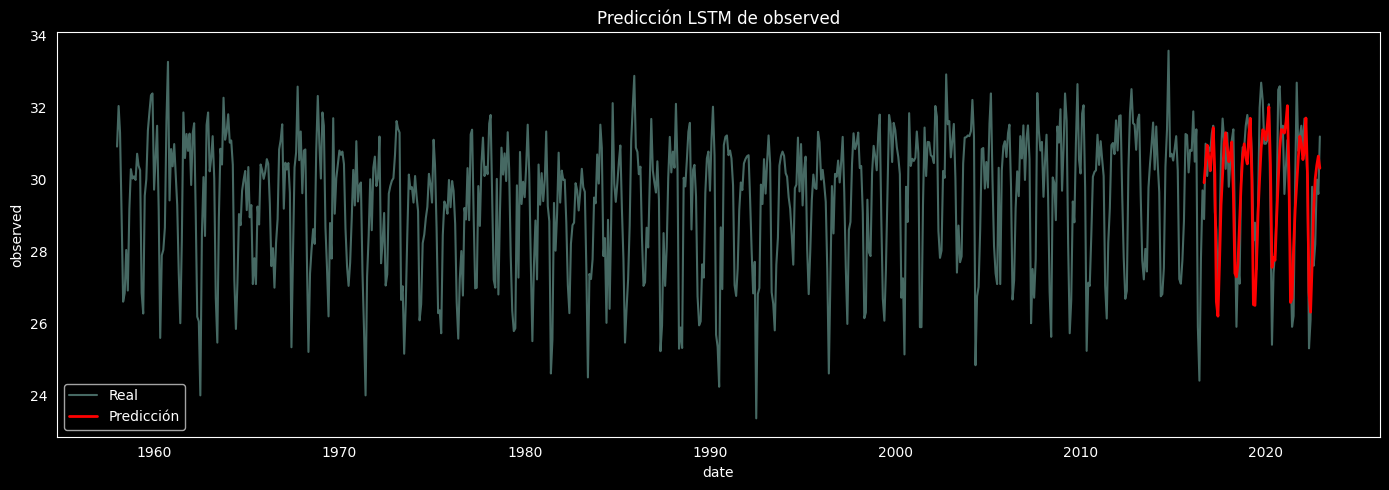

In [7]:
n_steps_o = 24

model_args_o = [
    {'layer': 'Input', 'units': (n_steps_o, 3), 'args': {}},
    {'layer': 'LSTM', 'units':32, 'args': {'return_sequences': False, 'use_cudnn': False}},
    {'layer': 'Dense', 'units': 1, 'args': {}},
]

compile_args_o = {
    'optimizer': 'adam',
    'loss': 'mse',
    'metrics': ['mse'],
}

training_args_o = {
    'epochs': 150,
    'batch_size': 24,
    'validation_split': 0.1,
    'callbacks': [EarlyStopping(patience=20, restore_best_weights=True)],
    'verbose': 0
}

ad_o = train_model(
    target_column=target,
    date_col='date',
    train_column='observed',
    n_steps=n_steps_o,
    training_args=training_args_o,
    model_args=model_args_o,
    compile_args=compile_args_o
)

%RMSE: 95.94129169725026
%MAE: 72.20855210956776


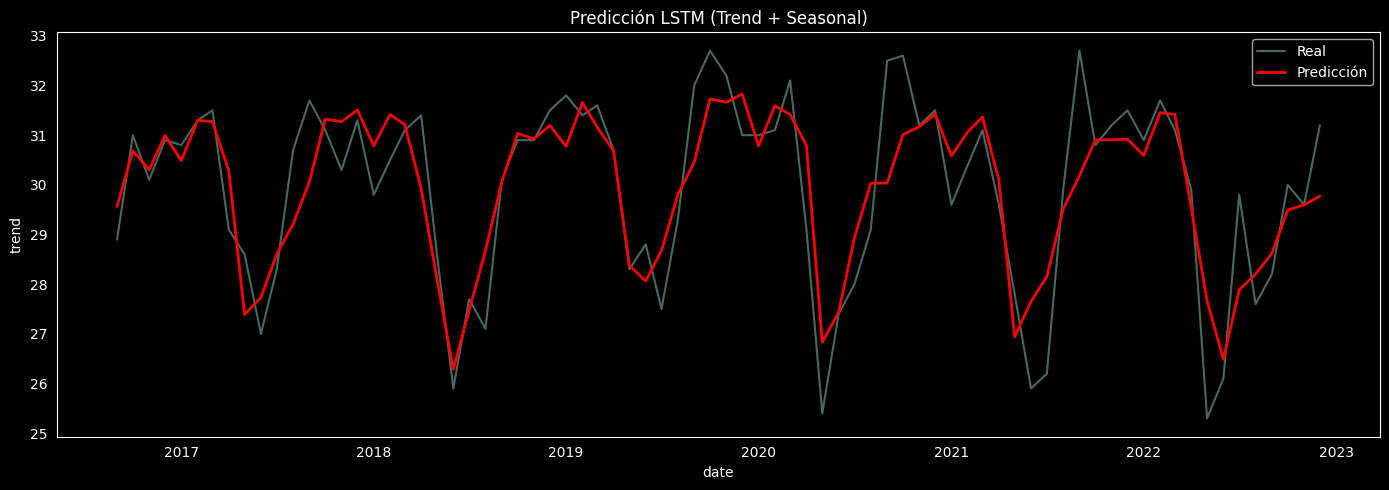

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Encontrar la longitud mínima entre las predicciones verdaderas de los modelos
min_len = min(
    len(ad_r._true_rescaled),
    len(ad_t._true_rescaled),
    len(ad_s._true_rescaled)
)

# Recortar las verdaderas y predichas para que tengan la misma longitud (solo trend + seasonal)
true_rescaled = (
    ad_t._true_rescaled[-min_len:]
    + ad_s._true_rescaled[-min_len:]
    + ad_r._true_rescaled[-min_len:]
)

pred_rescaled = (
    ad_t._pred_rescaled[-min_len:]
    + ad_s._pred_rescaled[-min_len:]
    + ad_r._pred_rescaled[-min_len:]
)

# Aplanar los arrays para matplotlib
true_rescaled = true_rescaled.flatten()
pred_rescaled = pred_rescaled.flatten()

# Calcular métricas
rmse = np.sqrt(mean_squared_error(true_rescaled, pred_rescaled))
mae = mean_absolute_error(true_rescaled, pred_rescaled)
print("%RMSE:", rmse * 100)
print("%MAE:", mae * 100)

# Usar las fechas del modelo trend para el eje x, recortadas al mismo rango
dates = ad_t._test_dates[-min_len:]

# Graficar
plt.figure(figsize=(14,5))
plt.plot(dates, true_rescaled, label="Real", alpha=0.5)
plt.plot(dates, pred_rescaled, label="Predicción", color="red", linewidth=2)
plt.title("Predicción LSTM (Trend + Seasonal)")
plt.xlabel(ad_t._date_col)
plt.ylabel(ad_t._target_col)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


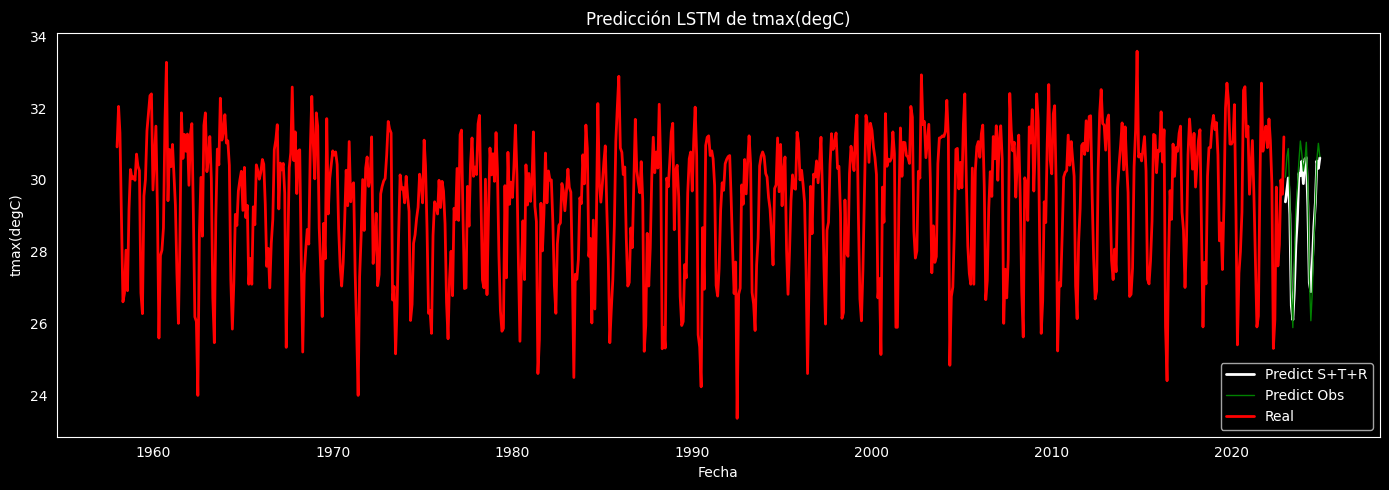

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
def build_dates(year):
    return [f'{year}{month}01' if month >= 10 else f'{year}0{month}01' for month in range(1, 13)]
dates_input = build_dates(2023)
dates_input = dates_input + build_dates(2024)
predicts = []
predicts1 = []
for date in dates_input:
    _predict = ad_r.predict_for_date(date)
    _predict += ad_t.predict_for_date(date)
    _predict += ad_s.predict_for_date(date)
    predicts.append(_predict)

    _predict = ad_o.predict_for_date(date)
    predicts1.append(_predict)


plt.figure(figsize=(14,5))
plt.plot(pd.to_datetime(dates_input, format='%Y%m%d'), predicts, label="Predict S+T+R", color='white', linewidth=2)
plt.plot(pd.to_datetime(dates_input, format='%Y%m%d'), predicts1, label="Predict Obs", color='green', linewidth=1)
plt.plot(ad_r.df['date'], ad_r.df['observed'], label="Real", color="red", linewidth=2)
plt.title("Predicción LSTM de " + target)
plt.xlabel("Fecha")
plt.ylabel(target)
plt.legend()
plt.grid()
plt.tight_layout()